In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn
import os
os.chdir('/Volume/VAD/UAADF/')
import torch
import torch.nn as nn 
import  torch.nn.functional as F 
from arguments import parser
from torch.utils.data import DataLoader
from datasets import create_dataset
from accelerate import Accelerator
import matplotlib.pyplot as plt 
import seaborn as sns 
from utils import img_show, img_cvt

from main import torch_seed
import random 

from query_strategies.sampler import SubsetSequentialSampler
from query_strategies.refinement import Refinementer


torch_seed(0)
torch.autograd.set_detect_anomaly(True)
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

def prepare(dataset, class_name, anomaly_ratio, baseline, weight_method, threshold):
    dataset = 'pc_mvtecad' if dataset == 'mvtecad' else 'pc_mvtecloco'
    default_setting = f'./configs/benchmark/{dataset}.yaml'
    cfg = parser(jupyter=True, default_setting = default_setting)
    cfg.DATASET.class_name = class_name 
    cfg.DATASET.params.anomaly_ratio = anomaly_ratio
    cfg.DATASET.params.baseline = baseline 
    cfg.MODEL.params.weight_method = weight_method 
    cfg.MODEL.params.threshold = threshold
    
    trainset, testset = create_dataset(
        dataset_name  = cfg.DATASET.dataset_name,
        datadir       = cfg.DATASET.datadir,
        class_name    = cfg.DATASET.class_name,
        img_size      = cfg.DATASET.img_size,
        mean          = cfg.DATASET.mean,
        std           = cfg.DATASET.std,
        aug_info      = cfg.DATASET.aug_info,
        **cfg.DATASET.get('params',{})
    )

    method            = cfg.MODEL.method
    backbone          = cfg.MODEL.backbone
    model_params      = cfg.MODEL.get('params',{})

    batch_size       = cfg.DATASET.batch_size
    test_batch_size  = cfg.DATASET.test_batch_size
    num_workers      = cfg.DATASET.num_workers

    # # define train dataloader
    trainloader = DataLoader(
        dataset     = trainset,
        batch_size  = batch_size,
        num_workers = num_workers,
        shuffle     = False
    )

    # define test dataloader
    testloader = DataLoader(
        dataset     = testset,
        batch_size  = test_batch_size,
        shuffle     = False,
        num_workers = num_workers
    )

    refinement = Refinementer(
            model          = __import__('models').__dict__[method](
                            backbone = backbone,
                            **model_params
                            ),
            n_query        = cfg.REFINEMENT.n_query,
            dataset        = trainset,
            unrefined_idx  = np.ones(len(trainset)).astype(np.bool8),
            batch_size     = batch_size,
            test_transform = testset.transform,
            num_workers    = num_workers
        )
    model = refinement.init_model()
    device = cfg.MODEL.params.device
    
    output = {}
    output['trainloader'], output['testloader'], output['model'], output['device']  = trainloader, testloader, model, device
    
    return output 

def train(inputs):
    trainloader, device, model = inputs['trainloader'], inputs['device'], inputs['model']
    for imgs, labels, gts in trainloader:
        output = model(imgs.to(device))
        loss = model.criterion(output)
    model.fit()
    
def evaluation(inputs, loco = False):
    testloader,  model = inputs['testloader'], inputs['model']
    from utils.metrics import MetricCalculator, loco_auroc

    model.eval()
    img_level = MetricCalculator(metric_list = ['auroc','average_precision','confusion_matrix'])
    pix_level = MetricCalculator(metric_list = ['auroc','average_precision','confusion_matrix','aupro'])

    results = {} 
    for idx, (images, labels, gts) in enumerate(testloader):
        
        # predict
        if model.__class__.__name__ in ['PatchCore']:
            score, score_map = model.get_score_map(images)
                
        # Stack Scoring for metrics 
        pix_level.update(score_map,gts.type(torch.int))
        img_level.update(score, labels.type(torch.int))
        
    p_results = pix_level.compute()
    i_results = img_level.compute()
    
    
    if loco:
        results['loco_auroc'] = loco_auroc(pix_level,testloader)
        results['loco_auroc'] = loco_auroc(img_level,testloader)    
        return p_results, i_results, results 
    else:         
        return p_results, i_results

def patch_scoring(testloader, model):
    self = model 
    score_list = [] 
    for imgs, labels, gts in testloader: 
        images = imgs.to(torch.float).to(self.device)
        _ = self.forward_modules.eval()

        with torch.no_grad():
            features, patch_shapes = self._embed(images, provide_patch_shapes=True)
            features = np.asarray(features)

            image_scores, _, indices = self.anomaly_scorer.predict([features])
        
        score_list.append(image_scores)
    score_list = np.concatenate(score_list)
    return score_list 

def test_scoring(inputs):
    'test 데이터들의 각 anomaly score 산출'
    score_list = [] 
    score_map_list = [] 
    with torch.no_grad():
        for imgs, labels, gts in inputs['testloader']:
            score, score_map = inputs['model'].get_score_map(imgs)
            score_list.append(score)
            score_map_list.append(score_map)
    S = np.concatenate(score_list)
    SM = np.concatenate(score_map_list)
    return S, SM 

def scaling(inputs):
    inputs = (inputs - np.min(inputs)) / (np.max(inputs) - np.min(inputs))
    return inputs 
        
        
def get_indicies(inputs, lof:bool = False):
    '''
    denoising 한 index와 coreset index 구하는 메소드 
    '''
    self = inputs['model']
    
    train_embeddings = np.vstack([inputs['model'].embed(d.to('cuda')) for d,_,_ in inputs['trainloader']])
    features = train_embeddings
    
    if lof:
        with torch.no_grad():
            # pdb.set_trace()
            self.feature_shape = [28,28]
            patch_weight = self._compute_patch_weight(features) # <- get outlier score 

            # normalization
            # patch_weight = (patch_weight - patch_weight.quantile(0.5, dim=1, keepdim=True)).reshape(-1) + 1

            patch_weight = patch_weight.reshape(-1)
            threshold = torch.quantile(patch_weight, 1 - self.threshold)
            sampling_weight = torch.where(patch_weight > threshold, 0, 1) #! sampling_weight = denoising 한 index 
            #self.featuresampler.set_sampling_weight(sampling_weight) # <- subsampling data which has outlier score under thresholding
            #self.patch_weight = patch_weight.clamp(min=0)
    
    sample_features, sample_indices = self.featuresampler.run(features) #! sample_indices = coreset index         
                
    if lof:
        return {'denoising':sampling_weight.detach().cpu(), 'coreset': sample_indices}
    else:
        return {'coreset': sample_indices}
                


# Denoising AutoEncoder 

In [57]:
inputs = prepare('mvtecad','screw',0.05,False,'lof',0.15)
train(inputs)
#p_results, i_results = evaluation(inputs)
model = inputs['model']

Subsampling...: 100%|██████████| 25088/25088 [00:18<00:00, 1360.31it/s]


In [4]:
import torch.nn as nn 
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        self.conv1 = nn.Conv2d(128, 256, 3, padding=1)  
        self.conv2 = nn.Conv2d(256, 512, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4096, 4096, 1, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(, 16, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
                
        return x

In [73]:
results = [] 
sns.set(style="whitegrid")  # Set the background style

lof = [] 
for i,ar in enumerate([0.05, 0.1, 0.2]):
    inputs = prepare('mvtecad','screw',ar,False,'lof', 0.15)
    trainloader, device, model = inputs['trainloader'], inputs['device'], inputs['model']

    labels = list() 
    for imgs, label, gts in trainloader:
        labels.append(label.detach().cpu().numpy())
    labels = np.concatenate(labels)    
    train(inputs)

    sample_indices = model.sample_indices
    coreset_labels = [] 
    for idx in sample_indices:
        i_idx = idx//784    
        coreset_labels.append(labels[i_idx])
        
    result = dict(pd.Series(coreset_labels).value_counts())    
    results.append(result)
    
    patch_weight = model.patch_weight.detach().cpu().numpy()    
    coreset_weight = patch_weight[sample_indices]        
    
    sampling_weight = model.sampling_weight
    
    coreset_indicies = sample_indices
    denoise_indicies = np.where(sampling_weight==0)[0]
    coreset_labels = np.array(coreset_labels)

    lof_score = model.patch_weight.detach().cpu().numpy()
    patch_labels = np.broadcast_to(labels.reshape(-1,1),(320,28*28)).reshape(-1)
    
    lof.append(lof_score[coreset_indicies[np.where(coreset_labels==1)[0]]])

Subsampling...: 100%|██████████| 25088/25088 [00:18<00:00, 1350.56it/s]


In [ ]:
sns.set(style="whitegrid") 
fig,ax = plt.subplots(1,1,figsize=(10,10))

sns.kdeplot(lof_score,
            linewidth=3,
            palette='Set2',
            label = 'Total LOF Score',
            alpha=0.7,
            ax = ax)
sns.kdeplot(lof_score[np.where(patch_labels==0)[0]],
            linewidth=3,
            palette='Set2',
            label = "Normal Image",
            alpha=0.7,
            ax = ax)
sns.kdeplot(lof_score[np.where(patch_labels==1)[0]],
            linewidth=3,
            palette='Set2',
            label = 'Anomaly Image',
            alpha=0.7,
            ax = ax)
ax.grid(True, linestyle='--',alpha=0.7)
ax.set_xlabel('LOF Score', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
# plt.ylim(0,0.1)
# plt.xlim(1.6,2.4)
ax.legend(fontsize=18)
plt.tight_layout()
plt.show()

<ipython-input-69-e2a0ddcb44b8>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(lof_score,
<ipython-input-69-e2a0ddcb44b8>:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(lof_score[coreset_indicies[np.where(coreset_labels==0)[0]]],
<ipython-input-69-e2a0ddcb44b8>:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(lof_score[coreset_indicies[np.where(coreset_labels==1)[0]]],


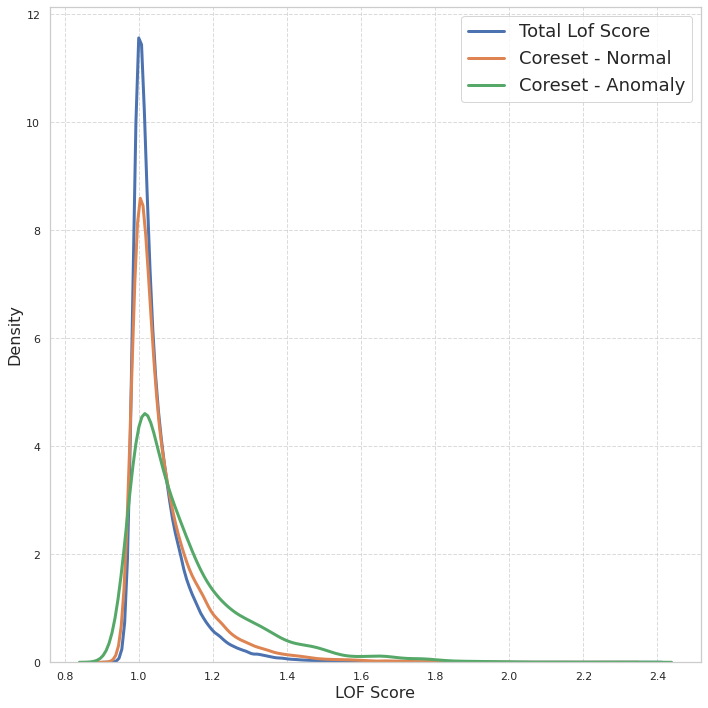

In [69]:
sns.set(style="whitegrid") 
fig,ax = plt.subplots(1,1,figsize=(10,10))

sns.kdeplot(lof_score,
            linewidth=3,
            palette='Set2',
            label = 'Total Lof Score',
            ax = ax)
sns.kdeplot(lof_score[coreset_indicies[np.where(coreset_labels==0)[0]]],
            linewidth=3,
            palette='Set2',
            label = 'Coreset - Normal',
            ax = ax)
sns.kdeplot(lof_score[coreset_indicies[np.where(coreset_labels==1)[0]]],
            linewidth=3,
            palette='Set2',
            label = 'Coreset - Anomaly',
            ax = ax)
ax.grid(True, linestyle='--',alpha=0.7)
ax.set_xlabel('LOF Score', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
# plt.ylim(0,0.1)
# plt.xlim(1.6,2.4)
ax.legend(fontsize=18)
plt.tight_layout()
plt.show()

<ipython-input-82-e4bb6675c2a5>:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(lof[0],
<ipython-input-82-e4bb6675c2a5>:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(lof[1],
<ipython-input-82-e4bb6675c2a5>:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(lof[2],


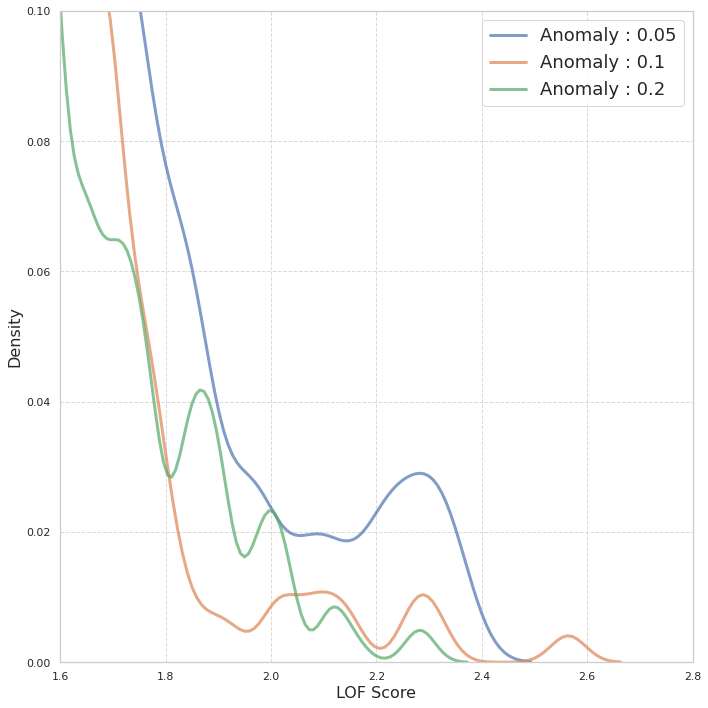

In [82]:
sns.set(style="whitegrid") 
fig,ax = plt.subplots(1,1,figsize=(10,10))

sns.kdeplot(lof[0],
            linewidth=3,
            palette='Set2',
            label = 'Anomaly : 0.05',
            alpha=0.7,
            ax = ax)
sns.kdeplot(lof[1],
            linewidth=3,
            palette='Set2',
            label = "Anomaly : 0.1",
            alpha=0.7,
            ax = ax)
sns.kdeplot(lof[2],
            linewidth=3,
            palette='Set2',
            label = 'Anomaly : 0.2',
            alpha=0.7,
            ax = ax)
ax.grid(True, linestyle='--',alpha=0.7)
ax.set_xlabel('LOF Score', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
plt.ylim(0,0.1)
plt.xlim(1.6,2.8)
ax.legend(fontsize=18)
plt.tight_layout()
plt.show()

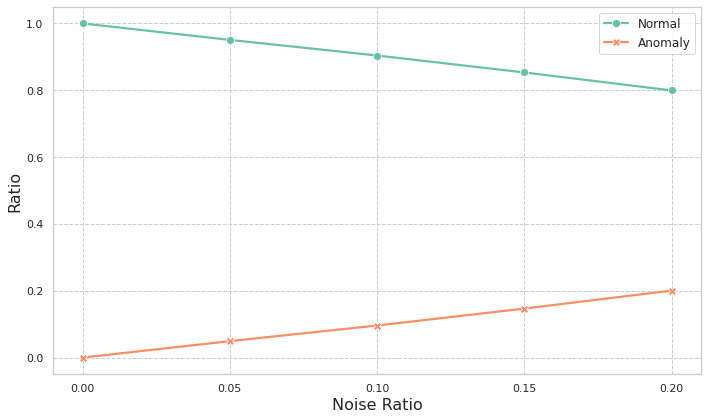

In [57]:
results[0][1] = 0 
df = pd.DataFrame(results)
df['total'] = df.sum(axis=1)
df.columns = ['Normal','Anomaly','Total']

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 각 행의 총합 계산


# 각 행의 값을 해당 행의 총합으로 나누어 비율 계산
df_ratios = df[['Normal','Anomaly']].div(df['Total'], axis=0)

# row index를 변경
df_ratios.index = [0,0.05,0.1,0.15,0.2]

# Seaborn을 사용하여 누적 영역형 그래프 그리기
fig, ax = plt.subplots(1,1, figsize=(10,6))

sns.lineplot(data=df_ratios, dashes=False, palette="Set2",
             linewidth=2.2,
            markers=True,  
            marker='o',
            markersize=8,
            errorbar=None  
             )
ax.legend(fontsize=12)
ax.set_xlabel('Noise Ratio', size=16)
ax.set_ylabel('Ratio', size=16)
ax.grid(True, linestyle='--')


plt.xticks([0,0.05,0.1,0.15,0.2])
plt.tight_layout()

plt.show()


In [61]:
patch_weight = patch_weight.reshape(320,28*28)

(250880,)

In [76]:
lof_score = model.patch_weight.detach().cpu().numpy()

(0.0, 9.0)

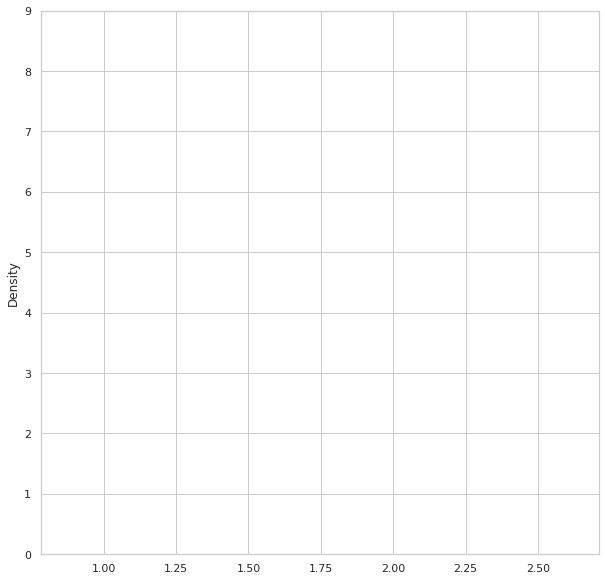

In [86]:
# results = [] 
# sns.set(style="whitegrid")  # Set the background style

# for i,ar in enumerate([0, 0.05, 0.1, 0.15, 0.2]):
#     inputs = prepare('mvtecad','screw',ar,False,'lof', 0.15)
#     trainloader, device, model = inputs['trainloader'], inputs['device'], inputs['model']

#     labels = list() 
#     for imgs, label, gts in trainloader:
#         labels.append(label.detach().cpu().numpy())
#     labels = np.concatenate(labels)    
#     train(inputs)

#     sample_indices = model.sample_indices
#     coreset_labels = [] 
#     for idx in sample_indices:
#         i_idx = idx//784    
#         coreset_labels.append(labels[i_idx])
        
#     result = dict(pd.Series(coreset_labels).value_counts())    
#     results.append(result)
    
#     patch_weight = model.patch_weight.detach().cpu().numpy()    
#     coreset_weight = patch_weight[sample_indices]        
    
#     sampling_weight = model.sampling_weight
    
# coreset_indicies = sample_indices
# denoise_indicies = np.where(sampling_weight==0)[0]
# coreset_labels = np.array(coreset_labels)


fig,ax = plt.subplots(1,1, figsize=(10,10))
sns.kdeplot(lof_score[np.where(coreset_labels==0)[0]],alpha=0)
sns.kdeplot(lof_score[np.where(coreset_labels==1)[0]],alpha=0)
plt.ylim(0,9)